Initial test python code

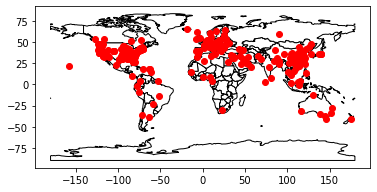

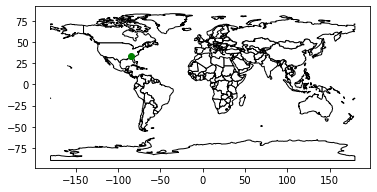

                 state
123  Fulton County, GA Is your closest confirmed location of COVID19 with a distance of: 4.2903119007782955


In [66]:
import pandas as pd
import numpy as np
import geopandas
from geopy import distance
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
from uszipcode import Zipcode
from sklearn.neighbors import BallTree


#Loaded from a personal file because the database was not wanting to load from github
url = r'C:\Users\Kacey Seidell\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports\03-09-2020.csv'


df = pd.read_csv(url, error_bad_lines=False)

df.columns = ['state', 'country','update','confirmed','deaths','recovered','latitude','longitude']

zip = "30322"
#Using the uszipcode engine to plot out coordinates for where you input your zip code to. 
search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database
zipcode = search.by_zipcode(zip)
zipdict = zipcode.to_dict()
zipsearch = pd.DataFrame.from_dict(zipdict)

#Creating the comparable dataframe
cities = pd.DataFrame(data={
    'name': df.country,
    'state': df.state,
    'lat': df.latitude,
    'lon': df.longitude
})

#Grabbing the results from the zipcode search, aka the lat an lng of current location
query_lats =int(zipsearch['lat'])
query_lons =int(zipsearch['lng'])
qmath = zipsearch[['lat','lng']]

#BallTree algorithm to determine via haversine nearest case
bt = BallTree(np.deg2rad(cities[['lat', 'lon']].values), metric='haversine')
distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]))

#Pulling into the nearest cities object based on the balltree results
nearest_cities = pd.DataFrame(cities.iloc[int(indices)])
#Transposing the dataset to make it work properly
nearest_cities = nearest_cities.T

#Simply checks to see if geometry is included after the tranposing and drops it if its still in there.
if 'geometry' in nearest_cities.columns :
    nearest_cities = nearest_cities.drop('geometry', axis=1)

nearmath = nearest_cities[['lat','lon']]

dis = distance.distance(qmath.to_numpy(),nearmath.to_numpy()).miles    
        
#All Cases Geoframe    
gdf = geopandas.GeoDataFrame(
    cities, geometry=geopandas.points_from_xy(cities.lon, cities.lat))
#Nearest Case to you dataframe
nearest = geopandas.GeoDataFrame(nearest_cities, geometry=geopandas.points_from_xy(nearest_cities.lon,nearest_cities.lat))

#Creating World Map with all cases
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot( color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()

#Creating World Map with only the nearest case
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot( color='white', edgecolor='black')
nearest.plot(ax=ax, color = 'green')
plt.show()

print(nearest_cities[['state']],"Is your closest confirmed location of COVID19 with a distance of:", dis)